In [127]:
import keras.backend as K
from keras.layers import Input, Add, Dense, Activation, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.constraints import max_norm
from keras.layers.noise import GaussianNoise
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score
import operator
import matplotlib.pyplot as plt
import config
import importlib
import os
import copy
import pandas as pd
import re
import numpy as np
from scipy.misc import imsave
import tensorflow as tf
%matplotlib inline

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = C.nb_classes

X_train = np.expand_dims(x_train,axis=3)
X_train = np.expand_dims(X_train,axis=4)
X_test = np.expand_dims(x_test,axis=3)
X_test = np.expand_dims(X_test,axis=4)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [131]:
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [132]:
C = config.Config()
dims = C.dims
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
x = voi_img
#x = GaussianNoise(1)(x)
#x = ZeroPadding3D(padding=(3,3,2))(voi_img)
#x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu')(x)
x = Conv3D(filters=32, kernel_size=(3,3,1), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
x = MaxPooling3D((2, 2, 1))(x)
x = Conv3D(filters=64, kernel_size=(3,3,2), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
#x = Conv3D(filters=128, kernel_size=(2,2,2), activation='relu')(x)
x = MaxPooling3D((2, 2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_constraint=max_norm(4.))(x)#, kernel_initializer='normal', kernel_regularizer=l1(.01), kernel_constraint=max_norm(3.))(x)
x = Dropout(0.5)(x)
pred_class = Dense(C.nb_classes, activation='softmax')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [133]:
optim = Adam(lr=0.01)#, decay=0.001)
early_stopping = EarlyStopping(min_delta=0.001, patience=10)

model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 24, 24, 12, 1)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 22, 22, 12, 32)    320       
_________________________________________________________________
dropout_28 (Dropout)         (None, 22, 22, 12, 32)    0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 11, 11, 12, 32)    0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 9, 9, 11, 64)      36928     
_________________________________________________________________
dropout_29 (Dropout)         (None, 9, 9, 11, 64)      0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 4, 4, 5, 64)       0         
__________

model2 = Model(voi_img, intermed)

for l in range(2,len(model2.layers)):
    model2.layers[l].set_weights(model.layers[l].get_weights())

X_train = []
Y_train = []

for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    Y_train.append([1,0])
for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    X_train[-1][5:15,5:15,5:7,0] = 2
    Y_train.append([0,1])
    
X_train = np.array(X_train) # X[:total_size//2]
#X_val = np.array(X_test)
Y_train = np.array(Y_train) # Y[:total_size//2]
#Y_val = np.array(Y_test)

In [134]:
classes = ['cyst', 'hcc', 'fnh', 'hemangioma', 'adenoma']

In [135]:
orig_data_dict = {}
num_samples = {}
    
for class_name in classes:#os.listdir(C.orig_dir):
    x = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    for index, img_fn in enumerate(os.listdir(C.orig_dir+class_name)):
        try:
            x[index] = np.load(C.orig_dir+class_name+"\\"+img_fn)
        except:
            raise ValueError(C.orig_dir+class_name+"\\"+img_fn + " not found")
        z.append(img_fn)
    
    x.resize((index, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    orig_data_dict[class_name] = [x,np.array(z)]
    num_samples[class_name] = index

In [136]:
num_samples

{'adenoma': 38, 'cyst': 74, 'fnh': 59, 'hcc': 50, 'hemangioma': 53}

In [138]:
train_ids = {} #filenames of training set originals
test_ids = {} #filenames of test set
X_test = []
Y_test = []
Z_test = []
X_train_orig = []
Y_train_orig = []
Z_train_orig = []
cls_mapping = []

train_frac = {"cyst": 0.75, "fnh": 0.75, "hcc": 0.75, "hemangioma": 0.75, 'adenoma': 0.75}
train_samples = {}

for cls_num, cls in enumerate(orig_data_dict):
    train_samples[cls] = round(num_samples[cls]*train_frac[cls])
    
    order = np.random.permutation(list(range(num_samples[cls])))
    train_ids[cls] = list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    test_ids[cls] = list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    
    X_test = X_test + list(orig_data_dict[cls][0][order[train_samples[cls]:]])
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (num_samples[cls] - train_samples[cls])
    Z_test = Z_test + list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    cls_mapping.append(cls)
    
    X_train_orig = X_train_orig + list(orig_data_dict[cls][0][order[:train_samples[cls]]])
    Y_train_orig = Y_train_orig + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (train_samples[cls])
    Z_train_orig = Z_train_orig + list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    
    print("%s has %d samples for training (%d after augmentation) and %d for testing" %
          (cls, train_samples[cls], train_samples[cls] * C.aug_factor[cls], num_samples[cls] - train_samples[cls]))

hcc has 38 samples for training (3800 after augmentation) and 12 for testing
cyst has 56 samples for training (5600 after augmentation) and 18 for testing
hemangioma has 40 samples for training (4000 after augmentation) and 13 for testing
adenoma has 28 samples for training (2800 after augmentation) and 10 for testing
fnh has 44 samples for training (4400 after augmentation) and 15 for testing


In [139]:
train_samples

{'adenoma': 28, 'cyst': 56, 'fnh': 44, 'hcc': 38, 'hemangioma': 40}

In [140]:
aug_data_dict = {}

for class_name in classes:#os.listdir(C.aug_dir):
    x_train = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    x_val = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    train_cnt = 0
    val_cnt = 0
    for img_fn in os.listdir(C.aug_dir+class_name):
            
        if "_".join(img_fn.split("_")[:2])+".npy" in train_ids[class_name]:
            try:
                x_train[train_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            train_cnt += 1
            z.append(img_fn)
            
        else:
            try:
                x_val[val_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            val_cnt += 1
    
    x_train.resize((train_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    x_val.resize((val_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    aug_data_dict[class_name] = {'train': [x_train,np.array(z)], 'val': x_val}

In [141]:
X_train = []
Y_train = []
Z_train = []
X_val = []
Y_val = []
Z_val = []

for cls_num, cls in enumerate(aug_data_dict):
    X_train = X_train + list(aug_data_dict[cls]['train'][0])
    Y_train = Y_train + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['train'][0])
    Z_train = Z_train + list(aug_data_dict[cls]['train'][1])
    
    X_val = X_val + list(aug_data_dict[cls]['val'])
    Y_val = Y_val + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['val'])

Z_cyst = data_dict["cyst"][1]

Y_[-4]

Z_cyst[-4]

X_cyst = data_dict["cyst"][0]
X_cyst = np.array(X_cyst) # X[:total_size//2]
X_cyst /= 255

X_hcc = data_dict["hcc"][0]
X_hcc = np.array(X_hcc) # X[:total_size//2]
X_hcc /= 255

In [142]:
X_train = np.array([2 * (x - np.amin(x)) / (np.amax(x) - np.amin(x)) - 1 for x in X_train]) #scale from -1 to 1
X_val = np.array([2 * (x - np.amin(x)) / (np.amax(x) - np.amin(x)) - 1 for x in X_val]) #scale from -1 to 1
X_test = np.array([2 * (x - np.amin(x)) / (np.amax(x) - np.amin(x)) - 1 for x in X_test]) #scale from -1 to 1
X_train_orig = np.array([2 * (x - np.amin(x)) / (np.amax(x) - np.amin(x)) - 1 for x in X_train_orig]) #scale from -1 to 1

#X_train = np.array(X_train) / 255 # X[:total_size//2]
#X_val = np.array(X_val) / 255
#X_test = np.array(X_test) / 255
#X_train_orig = np.array(X_train_orig) / 255

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_train_orig = np.array(Y_train_orig)

Z_train = np.array(Z_train)
Z_test = np.array(Z_test)
Z_train_orig = np.array(Z_train_orig)


In [28]:
#X = np.array([z for z in x])
#Y = np.array(y)
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

#total_size = X.shape[0]

#order = np.random.permutation(list(range(total_size)))
#X = X[order]
#Y = Y[order]

In [143]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_data=(X_val, Y_val)) #callbacks=[early_stopping]

Train on 10300 samples, validate on 3650 samples
Epoch 1/200
10300/10300 [==============================] - 11s - loss: 1.2053 - acc: 0.4845 - val_loss: 1.2972 - val_acc: 0.4507
Epoch 2/200
10300/10300 [==============================] - 8s - loss: 0.8984 - acc: 0.6287 - val_loss: 1.1724 - val_acc: 0.4989
Epoch 3/200
10300/10300 [==============================] - 8s - loss: 0.6761 - acc: 0.7271 - val_loss: 1.1261 - val_acc: 0.4896
Epoch 4/200
10300/10300 [==============================] - 8s - loss: 0.4865 - acc: 0.8098 - val_loss: 1.1090 - val_acc: 0.5008
Epoch 5/200
10300/10300 [==============================] - 8s - loss: 0.3723 - acc: 0.8483 - val_loss: 1.1300 - val_acc: 0.4975
Epoch 6/200
10300/10300 [==============================] - 8s - loss: 0.3026 - acc: 0.8861 - val_loss: 1.1618 - val_acc: 0.4918
Epoch 7/200
10300/10300 [==============================] - 8s - loss: 0.2489 - acc: 0.9072 - val_loss: 1.2457 - val_acc: 0.4978
Epoch 8/200
10300/10300 [=============================

10300/10300 [==============================] - 8s - loss: 0.0640 - acc: 0.9776 - val_loss: 1.5603 - val_acc: 0.5299
Epoch 65/200
10300/10300 [==============================] - 8s - loss: 0.0624 - acc: 0.9784 - val_loss: 1.4725 - val_acc: 0.5403
Epoch 66/200
10300/10300 [==============================] - 8s - loss: 0.0561 - acc: 0.9809 - val_loss: 1.4343 - val_acc: 0.5447
Epoch 67/200
10300/10300 [==============================] - 7s - loss: 0.0573 - acc: 0.9791 - val_loss: 1.4054 - val_acc: 0.5584
Epoch 68/200
10300/10300 [==============================] - 8s - loss: 0.0528 - acc: 0.9824 - val_loss: 1.5239 - val_acc: 0.5271
Epoch 69/200
10300/10300 [==============================] - 8s - loss: 0.0489 - acc: 0.9829 - val_loss: 1.5702 - val_acc: 0.5260
Epoch 70/200
10300/10300 [==============================] - 8s - loss: 0.0686 - acc: 0.9782 - val_loss: 1.4648 - val_acc: 0.5290
Epoch 71/200
10300/10300 [==============================] - 7s - loss: 0.0540 - acc: 0.9815 - val_loss: 1.5825

10300/10300 [==============================] - 8s - loss: 0.0553 - acc: 0.9825 - val_loss: 1.6365 - val_acc: 0.5274
Epoch 128/200
10300/10300 [==============================] - 8s - loss: 0.0484 - acc: 0.9850 - val_loss: 1.6036 - val_acc: 0.5186
Epoch 129/200
10300/10300 [==============================] - 8s - loss: 0.0519 - acc: 0.9839 - val_loss: 1.4804 - val_acc: 0.5389
Epoch 130/200
10300/10300 [==============================] - 8s - loss: 0.0392 - acc: 0.9864 - val_loss: 1.4723 - val_acc: 0.5321
Epoch 131/200
10300/10300 [==============================] - 7s - loss: 0.0321 - acc: 0.9901 - val_loss: 1.5541 - val_acc: 0.5318
Epoch 132/200
10300/10300 [==============================] - 8s - loss: 0.0360 - acc: 0.9876 - val_loss: 1.5139 - val_acc: 0.5203
Epoch 133/200
10300/10300 [==============================] - 8s - loss: 0.0486 - acc: 0.9849 - val_loss: 1.5391 - val_acc: 0.5238
Epoch 134/200
10300/10300 [==============================] - 8s - loss: 0.0381 - acc: 0.9876 - val_loss:

10300/10300 [==============================] - 8s - loss: 0.0500 - acc: 0.9860 - val_loss: 1.4891 - val_acc: 0.5167
Epoch 191/200
10300/10300 [==============================] - 7s - loss: 0.0397 - acc: 0.9866 - val_loss: 1.4710 - val_acc: 0.5241
Epoch 192/200
10300/10300 [==============================] - 8s - loss: 0.0452 - acc: 0.9869 - val_loss: 1.5482 - val_acc: 0.5488
Epoch 193/200
10300/10300 [==============================] - 8s - loss: 0.0355 - acc: 0.9883 - val_loss: 1.4537 - val_acc: 0.5605
Epoch 194/200
10300/10300 [==============================] - 8s - loss: 0.0332 - acc: 0.9889 - val_loss: 1.4960 - val_acc: 0.5493
Epoch 195/200
10300/10300 [==============================] - 8s - loss: 0.0450 - acc: 0.9850 - val_loss: 1.5782 - val_acc: 0.5345
Epoch 196/200
10300/10300 [==============================] - 8s - loss: 0.0412 - acc: 0.9883 - val_loss: 1.5169 - val_acc: 0.5318
Epoch 197/200
10300/10300 [==============================] - 8s - loss: 0.0403 - acc: 0.9864 - val_loss:

def train_generator(X, Y):
    while True:
        for i in range(len(X)):
            yield np.expand_dims(X[i], axis=0), np.expand_dims(Y[i], axis=0)

num_epochs = 10
epoch_length = 100
best_loss = np.Inf
losses = np.zeros(epoch_length)
acc = np.zeros(epoch_length)

data_gen_train = train_generator(X_train, Y_train)
for epoch_num in range(num_epochs):
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
    iter_num = 0
    
    while True:
        X, Y = next(data_gen_train)
        losses[iter_num], acc[iter_num] = model.train_on_batch(X, Y)

        iter_num += 1
        if iter_num == epoch_length:
            curr_loss = np.mean(losses)
            curr_acc = np.mean(acc)
            print("Mean Loss:", curr_loss, "// Mean Accuracy:", curr_acc)

            if curr_loss < best_loss:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model.save_weights(C.model_path)
            break

In [122]:
# TODO: modify to handle padding going out of bounds
def plot_with_bbox(fn, wrong_class, pad=15, draw_bbox=False, save_dir=None):
    voi_df = pd.read_csv('vois.csv')
    z = re.search(r'^(.*)_(\d*)\.', fn)
    
    img_fn = z.group(1) + ".npy"
    df = voi_df[voi_df["Filename"] == img_fn].iloc[int(z.group(2))]
    
    img = np.load("full_imgs\\"+img_fn)
    #if
    slice_num = (df['z1']+df['z2'])//2
    img_slice = img[:,:, slice_num, 0]
    img_slice = np.stack([img_slice, copy.deepcopy(img_slice), copy.deepcopy(img_slice)], axis=2)
    
    if draw_bbox:
        img_slice[df['x1']:df['x2'], df['y2'], 0] = 1
        img_slice[df['x1']:df['x2'], df['y2'], 1:] = 0
        
        img_slice[df['x1']:df['x2'], df['y1'], 0] = 1
        img_slice[df['x1']:df['x2'], df['y1'], 1:] = 0
        
        img_slice[df['x1'], df['y1']:df['y2'], 0] = 1
        img_slice[df['x1'], df['y1']:df['y2'], 1:] = 0
        
        img_slice[df['x2'], df['y1']:df['y2'], 0] = 1
        img_slice[df['x2'], df['y1']:df['y2'], 1:] = 0
        
    if save_dir is None:
        plot_section(img_slice, df, fn, pad=pad)
    else:
        plot_section(img_slice, df, fn, save_dir=save_dir+"\\"+df['cls'], wrong_class=wrong_class, pad=pad, noshow=True)

In [123]:
def get_cropped_slice(img_slice, df, pad):
    x1 = max(df['x1']-pad, 0)
    x2 = min(df['x2']+pad, img_slice.shape[0])
    y1 = max(df['y1']-pad, 0)
    y2 = min(df['y2']+pad, img_slice.shape[1])
    
    return img_slice[x1:x2, y2:y1:-1]

In [124]:
def plot_section(img_slice, row, fn, save_dir=None, wrong_class=None, pad=15, noshow=False):
    #plt.subplot(121)
    if noshow:
        ret = np.transpose(get_cropped_slice(img_slice, row, pad), (1,0,2))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        imsave("%s\\%s (pred %s).png" % (save_dir, fn[:-3], wrong_class), ret)
        
    else:
        ret = np.transpose(get_cropped_slice(img_slice[:,:,0], row, pad), (1,0))
        plt.imshow(ret, cmap='gray')
    #plt.subplot(122)

In [125]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

save_dir = "classified_imgs"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
#for i in range(len(Z_test)):
#    plot_with_bbox(Z_test[i], cls_mapping[np.array(y_pred)[i]], pad=30, draw_bbox=True, save_dir=save_dir)

In [56]:
Y_pred = model.predict(X_test)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]
cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

In [126]:
cm

array([[ 8,  1,  2,  1],
       [ 1, 14,  1,  2],
       [ 1,  4,  7,  1],
       [ 5,  1,  2,  6]], dtype=int64)

In [44]:
Y_pred = model.predict(X_train_orig)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#for i in range(len(Z_train_orig)):
#    plot_with_bbox(Z_train_orig[i], cls_mapping[np.array(y_pred)[i]], pad=30, draw_bbox=True, save_dir=save_dir)

In [365]:
fn_list = Z_test[~np.equal(y_pred, y_true)]
wrong_guesses = np.array(y_pred)[~np.equal(y_pred, y_true)]

In [409]:
Z_test[~np.equal(y_pred, y_true)]

array(['E100815762_0.npy', '12239513_0.npy', '12042703_2.npy'],
      dtype='<U16')

In [380]:
Z_test

array(['E105152534_0.npy', '13166464_0.npy', '12789019_1.npy',
       'E103514998_0.npy', 'E104430882_0.npy', '13064153_0.npy',
       '12857716_0.npy', '13064153_1.npy', 'E100718398_0.npy',
       'E101636006_0.npy', 'E105464882_0.npy', '12239513_0.npy',
       '12229245_0.npy', '12302576_2.npy', '12302576_0.npy'],
      dtype='<U16')

In [443]:
voi_df = pd.read_csv('vois.csv')
img_fn = "E100262351.npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=5)

ValueError: axes don't match array

In [159]:
activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

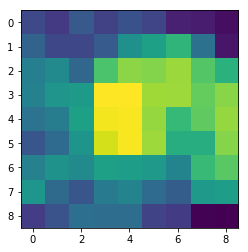

In [166]:
plt.imshow(activ[20][:,:,3,5])

In [162]:
activ[0][5,5,2,:]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  121.71251678,   53.23372269,    0.        ,
          0.        ,   24.43340492,    0.        ,    0.        ,
          0.        ,    0.        ,    7.88301706,    0.        ], dtype=float32)

In [316]:
import operator
#print("Ground truth:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_test)
print("Predictions:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% confidence)" % (max(x)*100) for x in Y_])

Predictions: ['hcc (95.75861% confidence)', 'hcc (99.98515% confidence)', 'hcc (56.77554% confidence)', 'hcc (97.68384% confidence)', 'hcc (96.73136% confidence)', 'hcc (99.99979% confidence)', 'hcc (99.99988% confidence)', 'hcc (99.71866% confidence)', 'cyst (63.61439% confidence)', 'cyst (51.41591% confidence)', 'hcc (99.65365% confidence)', 'hcc (52.72004% confidence)', 'hcc (57.44457% confidence)', 'cyst (99.82330% confidence)', 'cyst (83.69393% confidence)']


In [20]:
Y_[-1]

array([  2.78843247e-04,   9.99721110e-01], dtype=float32)

In [19]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6875

In [87]:
len(X_val)

210

In [84]:
import time

In [86]:
a=time.time()
Y_ = model.predict(X_val)
print(time.time()-a)

0.20054101943969727


In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

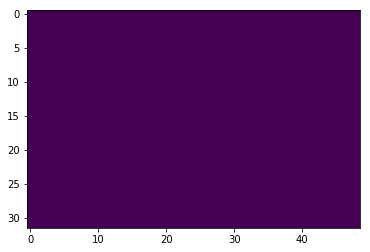

In [140]:
plt.imshow(X[0,:,:,5,0])